In [1]:
%reload_kedro

2021-04-19 20:56:21,856 - root - INFO - Registered hooks from 2 installed plugin(s): kedro-mlflow-0.7.0
2021-04-19 20:56:21,870 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.


/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/kedro/framework/project/__init__.py:133: UserWarning: Found duplicate pipeline entries. The following will be overwritten: __default__
  warn(


2021-04-19 20:56:22,008 - root - INFO - ** Kedro project viabill
2021-04-19 20:56:22,014 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-04-19 20:56:22,065 - root - INFO - Registered line magic `run_viz`


In [2]:
import viabill



In [3]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


In [4]:
df = catalog.load('df_train')

2021-04-19 20:56:22,116 - kedro.io.data_catalog - INFO - Loading data from `df_train` (ParquetDataSet)...


In [5]:
categorical_cols = ['sex', 'residentialAddress_clean',
                    'postalAddress_clean', 'geo_risk_rank', 'shopID',
                    'same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df.filter(regex='(^hist_)|(_lst_)').columns.to_list()
target_column = ['default']

In [6]:
categorical_cols

['sex',
 'residentialAddress_clean',
 'postalAddress_clean',
 'geo_risk_rank',
 'shopID',
 'same_address']

In [7]:
numerical_cols

['age',
 'income',
 'price',
 'hist_trans_count',
 'hist_default_sum',
 'hist_default_avg',
 'hist_late_sum',
 'hist_late_avg',
 'hist_price_sum',
 'hist_price_avg',
 'default_lst_01_sum',
 'defualted_payment_lst_01_sum',
 'money_lost_lst_01_sum',
 'late_lst_01_sum',
 'price_lst_01_sum',
 'late_payment_first_lst_01_sum',
 'default_lst_01_avg',
 'defualted_payment_lst_01_avg',
 'money_lost_lst_01_avg',
 'late_lst_01_avg',
 'price_lst_01_avg',
 'late_payment_first_lst_01_avg',
 'default_lst_03_sum',
 'defualted_payment_lst_03_sum',
 'money_lost_lst_03_sum',
 'late_lst_03_sum',
 'price_lst_03_sum',
 'late_payment_first_lst_03_sum',
 'default_lst_03_avg',
 'defualted_payment_lst_03_avg',
 'money_lost_lst_03_avg',
 'late_lst_03_avg',
 'price_lst_03_avg',
 'late_payment_first_lst_03_avg',
 'default_lst_06_sum',
 'defualted_payment_lst_06_sum',
 'money_lost_lst_06_sum',
 'late_lst_06_sum',
 'price_lst_06_sum',
 'late_payment_first_lst_06_sum',
 'default_lst_06_avg',
 'defualted_payment_lst_06

# Category features

In [8]:
import numpy as np
from collections import Counter


In [9]:
def calculate_IV(column, default_column = 'default', default_val=1, nondefault_val=0, df=df, ifprt = False):
    """
    calculate IV - temporary implementation
    """
    total = df.shape[0]
    total_event = np.sum(df[default_column]==default_val)
    total_nonevent= np.sum(df[default_column]==nondefault_val)

    def total_prc(x): return np.round(len(x)/total,4)
    def event_prc(x): return  np.round(len([i for i in list(x) if i==default_val])/total_event,4)
    def nonevent_prc(x): return  np.round(len([i for i in list(x) if i==nondefault_val])/total_nonevent,4)
    def woe(x): return np.log(nonevent_prc(x)/(event_prc(x)+np.finfo(float).eps))
    def iv(x): return (nonevent_prc(x)-event_prc(x))*woe(x)

    wyn = df[[column,default_column]].groupby(column).agg(
        ['count',total_prc,event_prc, nonevent_prc, woe,iv
        ])

    if ifprt:
        print(wyn)
    IV = np.sum(wyn.iloc[:,-1])
    if ifprt:
        print("\n IV value of variable '{}' is {}".format(column,np.round(IV,4)))
    return IV, wyn

In [10]:
IV_cat = {}
repl_dic = {}

## Sex

In [11]:
IV_cat['sex'], repl_dic['sex'] = calculate_IV('sex', default_column='default', ifprt=True)

2021-04-19 20:56:24,129 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.
       default                                                     
         count total_prc event_prc nonevent_prc       woe        iv
sex                                                                
female   63424    0.2001    0.3051       0.1896 -0.475723  0.054946
male    237598    0.7497    0.6189       0.7627  0.208921  0.030043
other    15920    0.0502    0.0760       0.0477 -0.465802  0.013182

 IV value of variable 'sex' is 0.0982


In [12]:
IV_cat['sex'], repl_dic['sex'] = calculate_IV('sex', default_column='late', ifprt=True)

          late                                                     
         count total_prc event_prc nonevent_prc       woe        iv
sex                                                                
female   63424    0.2001    0.1552       0.2189  0.343900  0.021906
male    237598    0.7497    0.8068       0.7258 -0.105801  0.008570
other    15920    0.0502    0.0380       0.0553  0.375187  0.006491

 IV value of variable 'sex' is 0.037


## geo_risk_rank

In [13]:
IV_cat['geo_risk_rank'], repl_dic['geo_risk_rank'] = calculate_IV('geo_risk_rank', default_column='default', ifprt=True)

              default                                                     
                count total_prc event_prc nonevent_prc       woe        iv
geo_risk_rank                                                             
0               25518    0.0805    0.0676       0.0818  0.190669  0.002708
1               58201    0.1836    0.1642       0.1856  0.122509  0.002622
2               69972    0.2208    0.2169       0.2212  0.019631  0.000084
3               76280    0.2407    0.2434       0.2404 -0.012402  0.000037
4               60926    0.1922    0.2054       0.1909 -0.073210  0.001062
5               26045    0.0822    0.1025       0.0801 -0.246587  0.005524

 IV value of variable 'geo_risk_rank' is 0.012


In [14]:
IV_cat['geo_risk_rank'], repl_dic['geo_risk_rank'] = calculate_IV('geo_risk_rank', default_column='late', ifprt=True)

                late                                                         
               count total_prc event_prc nonevent_prc           woe        iv
geo_risk_rank                                                                
0              25518    0.0805    0.0826       0.0797 -3.574009e-02  0.000104
1              58201    0.1836    0.1840       0.1835 -2.721090e-03  0.000001
2              69972    0.2208    0.2192       0.2214  9.986465e-03  0.000022
3              76280    0.2407    0.2410       0.2405 -2.076844e-03  0.000001
4              60926    0.1922    0.1922       0.1922 -1.110223e-15 -0.000000
5              26045    0.0822    0.0811       0.0826  1.832672e-02  0.000027

 IV value of variable 'geo_risk_rank' is 0.0002


## same_address (postalAddress & residentialAddress)

In [15]:
IV_cat['same_address'], repl_dic['same_address'] = calculate_IV('same_address', default_column='default', ifprt=True)

             default                                                     
               count total_prc event_prc nonevent_prc       woe        iv
same_address                                                             
0              21970    0.0693    0.2387       0.0524 -1.516301  0.282487
1             294972    0.9307    0.7613       0.9476  0.218905  0.040782

 IV value of variable 'same_address' is 0.3233


In [16]:
IV_cat['same_address'], repl_dic['same_address'] = calculate_IV('same_address', default_column='late', ifprt=True)

                late                                                     
               count total_prc event_prc nonevent_prc       woe        iv
same_address                                                             
0              21970    0.0693    0.0621       0.0723  0.152078  0.001551
1             294972    0.9307    0.9379       0.9277 -0.010935  0.000112

 IV value of variable 'same_address' is 0.0017


## shopID

In [17]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [18]:
%matplotlib inline
shopID_pca = df.groupby('shopID').agg(
    default_rate=('default', 'mean'),
    age_avg=('age', 'mean'),
    price_avg=('price', 'mean'),
    income_avg=('income','mean')
)


scaler = MinMaxScaler()
X=scaler.fit_transform(shopID_pca)

#pc = PCA(n_components=2, random_state=1)
#X=pc.fit_transform(X)

X = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300, random_state=1).fit_transform(X)


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 899 samples in 0.001s...
[t-SNE] Computed neighbors for 899 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 899 / 899
[t-SNE] Mean sigma: 0.074406
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.616844
[t-SNE] KL divergence after 300 iterations: 1.368713


<AxesSubplot:xlabel='x', ylabel='y'>

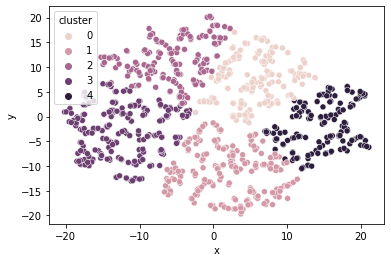

In [19]:
#clustering = DBSCAN(eps=0.07, min_samples=5).fit(X)
clustering = KMeans(n_clusters=5).fit(X)
set(clustering.labels_)

pca_clusters = pd.DataFrame(X, columns=['x','y']).assign(
    cluster=clustering.labels_, 
    dr=shopID_pca.default_rate)
sns.scatterplot(data=pca_clusters, x="x", y="y", hue="cluster")


In [20]:
shop_clusters = pd.DataFrame({'shopID':shopID_pca.index.to_list(), 'shop_cluster':clustering.labels_})
IV_cat['shop_cluster'], repl_dic['shop_cluster'] = calculate_IV('shop_cluster', default_column='late', df=df.merge(shop_clusters, on='shopID', how='left'), ifprt=True)


               late                                                     
              count total_prc event_prc nonevent_prc       woe        iv
shop_cluster                                                            
0             57109    0.1802    0.1816       0.1796 -0.011074  0.000022
1             71777    0.2265    0.2257       0.2268  0.004862  0.000005
2             57227    0.1806    0.1793       0.1811  0.009989  0.000018
3             76224    0.2405    0.2399       0.2407  0.003329  0.000003
4             54605    0.1723    0.1735       0.1718 -0.009847  0.000017

 IV value of variable 'shop_cluster' is 0.0001


## residentialAddress_clean

In [21]:
residentialAddress_clean_pca = df.groupby('residentialAddress_clean').agg(
    default_rate=('default', 'mean'),
    age_avg=('age', 'mean'),
    price_avg=('price', 'mean'),
    income_avg=('income','mean')
)

scaler = MinMaxScaler()
X=scaler.fit_transform(residentialAddress_clean_pca)

X = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300, random_state=1).fit_transform(X)



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13260 samples in 0.005s...
[t-SNE] Computed neighbors for 13260 samples in 0.639s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13260
[t-SNE] Computed conditional probabilities for sample 2000 / 13260
[t-SNE] Computed conditional probabilities for sample 3000 / 13260
[t-SNE] Computed conditional probabilities for sample 4000 / 13260
[t-SNE] Computed conditional probabilities for sample 5000 / 13260
[t-SNE] Computed conditional probabilities for sample 6000 / 13260
[t-SNE] Computed conditional probabilities for sample 7000 / 13260
[t-SNE] Computed conditional probabilities for sample 8000 / 13260
[t-SNE] Computed conditional probabilities for sample 9000 / 13260
[t-SNE] Computed conditional probabilities for sample 10000 / 13260
[t-SNE] Computed conditional probabilities for sample 11000 / 13260
[t-SNE] Computed conditional probabilities for sample 12000 / 13260
[t-SNE] Computed conditional probabilities for sam

<AxesSubplot:xlabel='x', ylabel='y'>

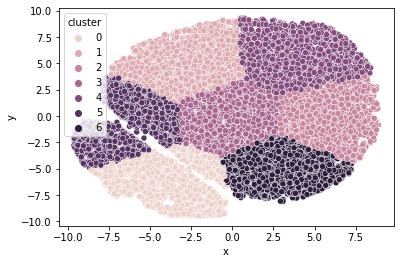

In [22]:
%matplotlib inline
#clustering = DBSCAN(eps=0.32, min_samples=10).fit(X)
clustering = KMeans(n_clusters=7).fit(X)
#clustering = AgglomerativeClustering(n_clusters=4).fit(X)
set(clustering.labels_)

pca_clusters = pd.DataFrame(X, columns=['x','y']).assign(
    cluster=clustering.labels_, 
    dr=residentialAddress_clean_pca.default_rate)
sns.scatterplot(data=pca_clusters, x="x", y="y", hue="cluster")


In [23]:
residentialAddress_clusters = pd.DataFrame({'residentialAddress_clean': residentialAddress_clean_pca.index.to_list(), 
              'residentialAddress_cluster':clustering.labels_})

IV_cat['residentialAddress_cluster'], repl_dic['residentialAddress_cluster'] = calculate_IV('residentialAddress_cluster', default_column='late', df=df.merge(residentialAddress_clusters, on='residentialAddress_clean', how='left'), ifprt=True)


                             late                                             \
                            count total_prc event_prc nonevent_prc       woe   
residentialAddress_cluster                                                     
0                           36509    0.1152    0.1201       0.1131 -0.060052   
1                           47576    0.1501    0.1494       0.1504  0.006671   
2                           43114    0.1360    0.1316       0.1379  0.046762   
3                           63736    0.2011    0.2033       0.2002 -0.015366   
4                           46784    0.1476    0.1392       0.1511  0.082030   
5                           37662    0.1188    0.1220       0.1175 -0.037583   
6                           41561    0.1311    0.1343       0.1298 -0.034081   

                                      
                                  iv  
residentialAddress_cluster            
0                           0.000420  
1                           0.000007  
2   

## postalAddress_clean

In [24]:
postalAddress_clean_pca = df.groupby('postalAddress_clean').agg(
    default_rate=('default', 'mean'),
    age_avg=('age', 'mean'),
    price_avg=('price', 'mean'),
    income_avg=('income','mean')
)

scaler = MinMaxScaler()
X=scaler.fit_transform(postalAddress_clean_pca)

X = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300, random_state=1).fit_transform(X)



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13261 samples in 0.013s...
[t-SNE] Computed neighbors for 13261 samples in 0.907s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13261
[t-SNE] Computed conditional probabilities for sample 2000 / 13261
[t-SNE] Computed conditional probabilities for sample 3000 / 13261
[t-SNE] Computed conditional probabilities for sample 4000 / 13261
[t-SNE] Computed conditional probabilities for sample 5000 / 13261
[t-SNE] Computed conditional probabilities for sample 6000 / 13261
[t-SNE] Computed conditional probabilities for sample 7000 / 13261
[t-SNE] Computed conditional probabilities for sample 8000 / 13261
[t-SNE] Computed conditional probabilities for sample 9000 / 13261
[t-SNE] Computed conditional probabilities for sample 10000 / 13261
[t-SNE] Computed conditional probabilities for sample 11000 / 13261
[t-SNE] Computed conditional probabilities for sample 12000 / 13261
[t-SNE] Computed conditional probabilities for sam

<AxesSubplot:xlabel='x', ylabel='y'>

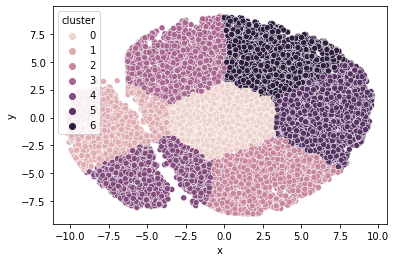

In [25]:
%matplotlib inline
#clustering = DBSCAN(eps=0.32, min_samples=10).fit(X)
clustering = KMeans(n_clusters=7).fit(X)
#clustering = AgglomerativeClustering(n_clusters=4).fit(X)
set(clustering.labels_)

pca_clusters = pd.DataFrame(X, columns=['x','y']).assign(
    cluster=clustering.labels_, 
    dr=postalAddress_clean_pca.default_rate)
sns.scatterplot(data=pca_clusters, x="x", y="y", hue="cluster")



In [26]:
postalAddress_clusters = pd.DataFrame({'postalAddress_clean': postalAddress_clean_pca.index.to_list(), 
              'postalAddress_cluster':clustering.labels_})

IV_cat['postalAddress_cluster'], repl_dic['postalAddress_cluster'] = calculate_IV('postalAddress_cluster', default_column='late', df=df.merge(postalAddress_clusters, on='postalAddress_clean', how='left'), ifprt=True)


                        late                                             \
                       count total_prc event_prc nonevent_prc       woe   
postalAddress_cluster                                                     
0                      71764    0.2264    0.2279       0.2258 -0.009257   
1                      33392    0.1054    0.1080       0.1043 -0.034860   
2                      46950    0.1481    0.1496       0.1475 -0.014137   
3                      45586    0.1438    0.1449       0.1434 -0.010406   
4                      33761    0.1065    0.1108       0.1047 -0.056628   
5                      43671    0.1378    0.1300       0.1410  0.081225   
6                      41818    0.1319    0.1287       0.1333  0.035118   

                                 
                             iv  
postalAddress_cluster            
0                      0.000019  
1                      0.000129  
2                      0.000030  
3                      0.000016  
4          

# Numerical

In [27]:
import matplotlib


In [28]:
from sklearn.preprocessing import KBinsDiscretizer

In [29]:
est = viabill.pipelines.model.DecisionTreeDiscretizer_DF(max_depth = 3, min_samples_prc_leaf=0.05)

In [30]:
num2cat_np = est.fit_transform(df[numerical_cols].fillna({'income':-999}), df.default)
num2cat = pd.DataFrame(num2cat_np, columns=num2cat_np.columns)

In [31]:
IV_num = {}
df_IV_num = {}

for col in num2cat.columns.to_list():
    IV_num[col], df_IV_num[col] = calculate_IV(col, default_column='default', df=pd.concat([num2cat,df['default']], axis=1))


In [32]:
pd.DataFrame([(i,IV_num[i]) for i in IV_num], columns=['feature', 'iv']).sort_values('iv', ascending=False).query("iv>0.01").reset_index()


,index,feature,iv
0,40,default_lst_06_avg,0.234209
1,52,default_lst_09_avg,0.233518
2,5,hist_default_avg,0.233406
3,64,default_lst_12_avg,0.233406
4,65,defualted_payment_lst_12_avg,0.225660
5,53,defualted_payment_lst_09_avg,0.225492
6,41,defualted_payment_lst_06_avg,0.224849
7,28,default_lst_03_avg,0.215565
8,29,defualted_payment_lst_03_avg,0.210290
9,42,money_lost_lst_06_avg,0.203530


In [33]:
best_numerical_default = pd.DataFrame([(i,IV_num[i]) for i in IV_num], columns=['feature', 'iv']).sort_values('iv', ascending=False).query("iv>0.05").reset_index(drop=True)
best_numerical_default

,feature,iv
0,default_lst_06_avg,0.234209
1,default_lst_09_avg,0.233518
2,hist_default_avg,0.233406
3,default_lst_12_avg,0.233406
4,defualted_payment_lst_12_avg,0.225660
5,defualted_payment_lst_09_avg,0.225492
6,defualted_payment_lst_06_avg,0.224849
7,default_lst_03_avg,0.215565
8,defualted_payment_lst_03_avg,0.210290
9,money_lost_lst_06_avg,0.203530


In [34]:
IV_num_late = {}
df_IV_num_late = {}

for col in num2cat.columns.to_list():
    IV_num_late[col], df_IV_num_late[col] = calculate_IV(col, default_column='late', df=pd.concat([num2cat,df['late']], axis=1))


In [35]:
best_numerical_late = pd.DataFrame([(i,IV_num_late[i]) for i in IV_num_late], columns=['feature', 'iv']).sort_values('iv', ascending=False).query("iv>0.01")
best_numerical_late


,feature,iv
67,late_lst_12_avg,0.164569
55,late_lst_09_avg,0.164406
7,hist_late_avg,0.163753
43,late_lst_06_avg,0.163724
37,late_lst_06_sum,0.150422
49,late_lst_09_sum,0.149015
6,hist_late_sum,0.148953
61,late_lst_12_sum,0.148953
31,late_lst_03_avg,0.147539
25,late_lst_03_sum,0.143543


In [36]:
list_bnd = best_numerical_default.feature.to_list()+['income']

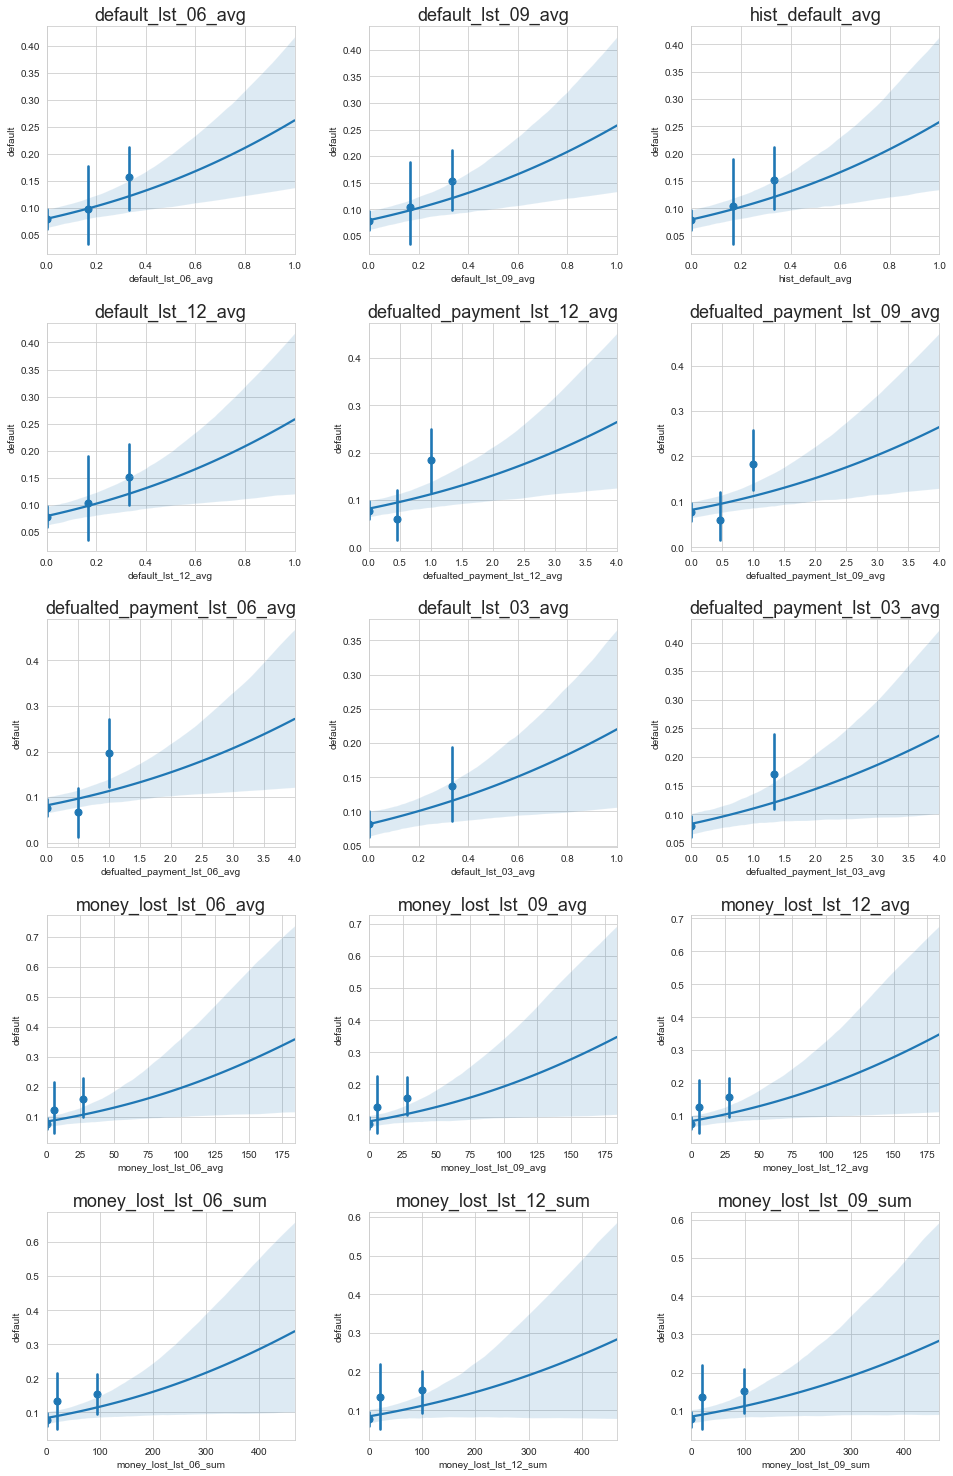

In [37]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16,26))
gs = matplotlib.gridspec.GridSpec(nrows=5, 
                       ncols=3, 
                       figure=fig, 
                       wspace=0.3,
                       hspace=0.3)

ax_dic = {}




counter = 0
for row in range(5):
    for col in range(3):
        if counter < len(list_bnd):
            col_name = list_bnd[counter]
            ax_dic[counter] = fig.add_subplot(gs[row, col])
            sns.regplot(x=col_name, y="default",logistic=True,y_jitter=.03,
                        data=df.sample(1000, random_state=666), x_bins=10, ax=ax_dic[counter])
            ax_dic[counter].set_title(col_name,fontsize=18)
            counter +=1
        

In [38]:
list_bnl = best_numerical_late.feature.to_list()+['income']

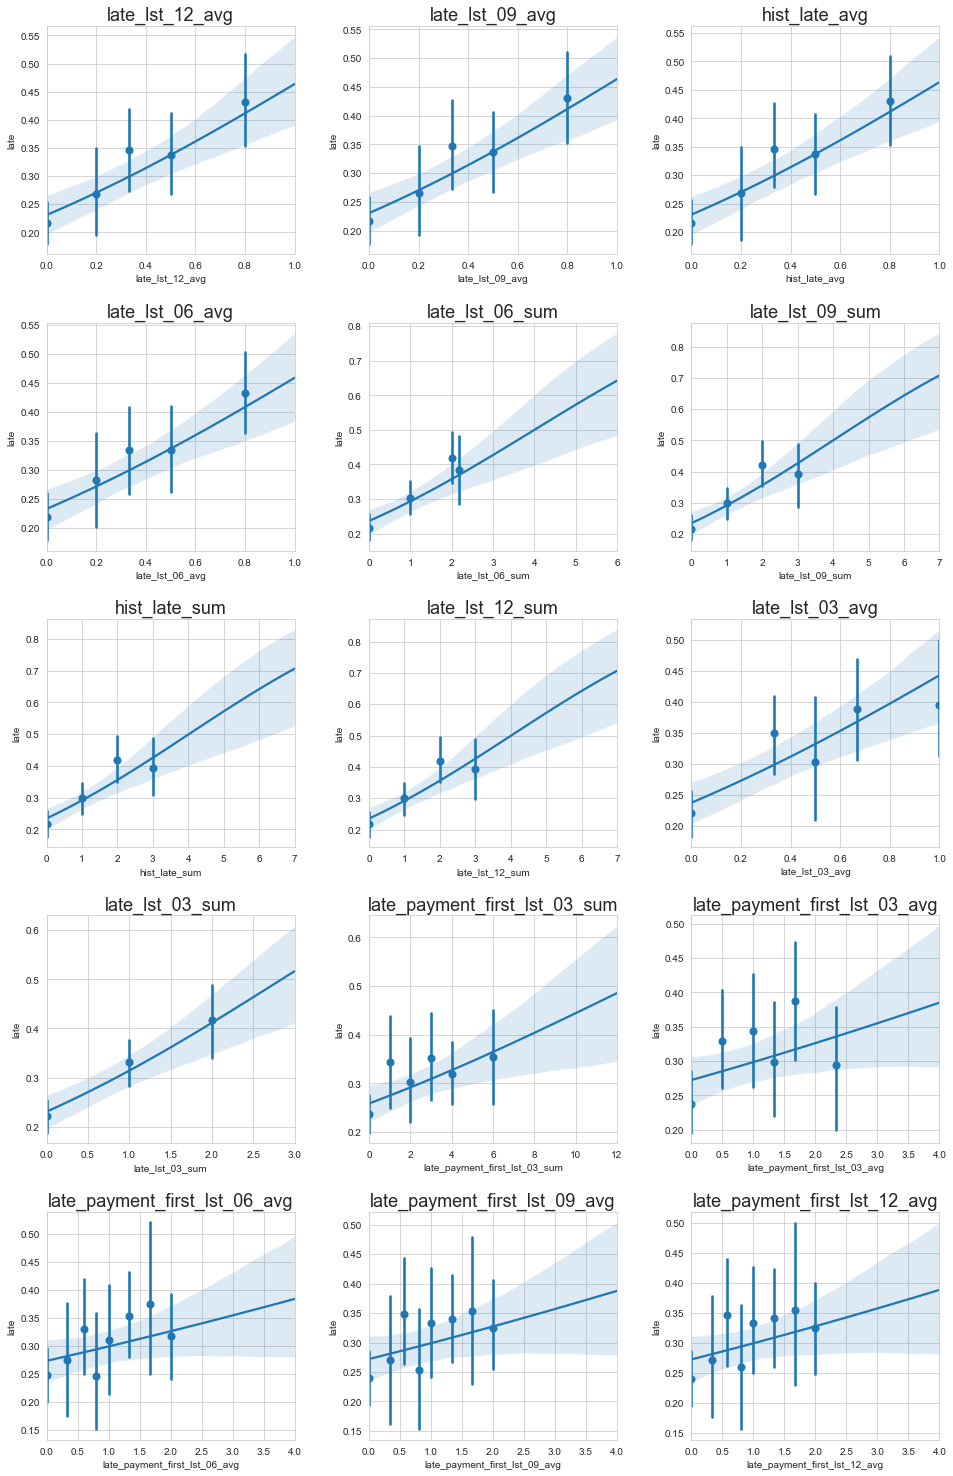

In [39]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16,26))
gs = matplotlib.gridspec.GridSpec(nrows=5, 
                       ncols=3, 
                       figure=fig, 
                       wspace=0.3,
                       hspace=0.3)

ax_dic = {}




counter = 0
for row in range(5):
    for col in range(3):
        if counter < len(list_bnl):
            col_name = list_bnl[counter]
            ax_dic[counter] = fig.add_subplot(gs[row, col])
            sns.regplot(x=col_name, y="late",logistic=True,y_jitter=.03,
                        data=df.sample(1000, random_state=666), x_bins=10, ax=ax_dic[counter])
            ax_dic[counter].set_title(col_name,fontsize=18)
            counter +=1
        